In [1]:
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score, roc_curve, auc, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_validate, train_test_split

from catboost import CatBoostClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

C:\Users\operator\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\operator\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\operator\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# weights = дисбаланс классов

X, y = make_classification(n_samples=2000, weights=[0.7, 0.3], n_features=50, n_informative=30)

In [3]:
X = pd.DataFrame(X)
y = pd.Series(y, name='target')

In [4]:
y.value_counts(normalize=True)

target
0    0.699
1    0.301
Name: proportion, dtype: float64

In [5]:
#df = pd.concat([pd.DataFrame(X), pd.Series(y, name='target')], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

In [7]:
model = CatBoostClassifier(n_estimators=10, verbose=False)

model.fit(X = X_train, 
          y = y_train, 
          eval_set=(X_test, y_test), 
          verbose=False) 

In [8]:
y_pred_train_model = model.predict_proba(X_train)[:, 1]
y_pred_test_model = model.predict_proba(X_test)[:, 1]

In [9]:
y_pred_train_r = np.random.sample(len(y_train))
y_pred_test_r = np.random.sample(len(y_test))

Создали датасет с фичами, таргетом и предикшном

###
### 1. ROC_AUC

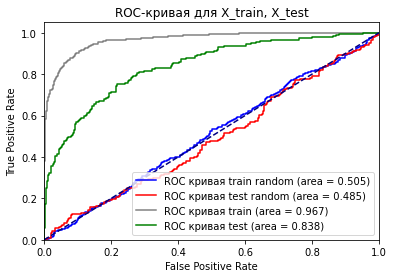

In [10]:
# Для рандома - близко к диагонали

fpr_train_r, tpr_train_r, thresholds_train_r = roc_curve(y_train, y_pred_train_r)
roc_auc_train_r = auc(fpr_train_r, tpr_train_r)

fpr_test_r, tpr_test_r, thresholds_test_r = roc_curve(y_test, y_pred_test_r)
roc_auc_test_r = auc(fpr_test_r, tpr_test_r)

# ----------------------------

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train_model)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test_model)
roc_auc_test = auc(fpr_test, tpr_test)

# ---------------------------

plt.plot(fpr_train_r, tpr_train_r, color='blue',
         label='ROC кривая train random (area = %0.3f)' % roc_auc_train_r)

plt.plot(fpr_test_r, tpr_test_r, color='red',
         label='ROC кривая test random (area = %0.3f)' % roc_auc_test_r)


plt.plot(fpr_train, tpr_train, color='grey',
         label='ROC кривая train (area = %0.3f)' % roc_auc_train)

plt.plot(fpr_test, tpr_test, color='green',
         label='ROC кривая test (area = %0.3f)' % roc_auc_test)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для X_train, X_test')
plt.legend(loc="lower right")
plt.show()

In [11]:
# более интерактивно в plotly 

import plotly.express as px

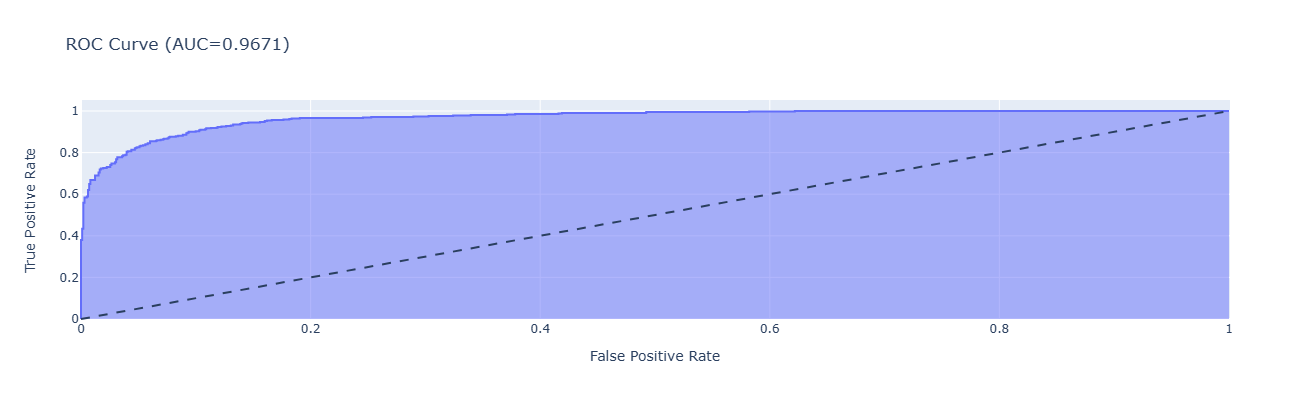

In [12]:
# На одном графике несколько линий там позапарнее через цикл предлагают

fig = px.area(x=fpr_train, 
              y=tpr_train, 
              width=600,           # ширина фигуры
              height=400,          # высота фигуры
              title=f'ROC Curve (AUC={roc_auc_train:.4f})',
              labels=dict(x='False Positive Rate', 
                          y='True Positive Rate'))

fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)

### 2. Разбиение скора модели на бакеты в зависимости от наших групп

In [13]:
df = pd.concat([pd.concat([X_train.reset_index(drop=True), 
                           y_train.reset_index(drop=True), 
                           pd.Series(y_pred_train_model, name='score').reset_index(drop=True)], axis=1),
                
                pd.concat([X_test.reset_index(drop=True), 
                           y_test.reset_index(drop=True), 
                           pd.Series(y_pred_test_model, name='score').reset_index(drop=True)], axis=1)] ) \
       .reset_index(drop=True)

<AxesSubplot:>

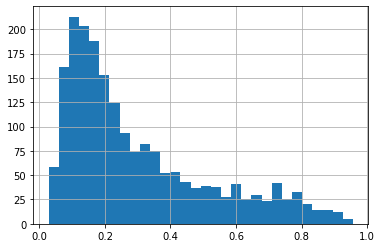

In [14]:
df.score.hist(bins=30)

In [15]:
# Этот словарь в зависимости от задачи и задает бакеты на которые мы все поделим
# Регулируя его, мы регулируем и график

my_scale_of_group = {0.0020000000000: 109, 
                     0.0140000000000: 110, 
                     0.0280000000000: 111, 
                     0.0420000000000: 112, 
                     0.0560000000000: 113, 
                     0.0700000000000: 114, 
                     0.0840000000000: 115, 
                     0.0980000000000: 116, 
                     0.1600000000000: 117, 
                     0.2811711454357: 118, 
                     0.4290040268516: 119, 
                     1.0000000000000: 120}

def percent_target_bucket_bar(df_i, scale='equal', equal_count=10, type_fig ='bar', interval_dict=my_scale_of_group):
    ''' 
    1. На вход - df из двух колонок: действительный "target" и предсказанные вероятности "score"
    2. На вход - шкала: 'equal' - делим скор на равные части, количество равно длине словаря, 
                       'forced' - делим скор на части, указанные в ключах словаря
                       
                       Ecли шкала == equal, то ставим equal_count = количество бакоетов, на которое хотим разделить
                       
    3. На вход - тип фигуры - 'bar' - столбцы с распределением таргета внутри бакета,
                              'bar_with_line' - процент таргета в сопоставлении с количеством записей в бакете
    4. На вход - бакеты в виде словаря {'верхняя граница': группа} (верхняя граница в пределах от 0 до 1) 
    
       На выход - график столбцов с долей таргета 
       На выход - таблица с расчетными данными, при использовании return
    '''
    if scale == 'equal':
        gr_count = equal_count
        gr_labels = [i for i in range(equal_count)]
    elif scale == 'forced':
        gr_count = len(interval_dict)
        gr_labels = interval_dict.values()
    else:
        print('error scale')
    
    equal_bins = [round((1 / gr_count) * (ind+1), 3) for ind, val in enumerate(range(gr_count))]           # список равномерных границ согласно количеству групп 
    forced_bins = [round(i, 3) for i in list(interval_dict.keys())]                                        # список границ согласно количеству групп и их значению
    
    if scale == 'equal':
        bins = equal_bins
        scale_ticks_for_figure = 'score_intervals'
    
    elif scale == 'forced':
        bins = forced_bins
        scale_ticks_for_figure = 'my_bins'
    else:
        print('error scale')
    

    df_i['score_intervals'] = pd.cut(df_i['score'], [0]+bins)                                              # делим скор на интервалы
    df_i['score_groups'] = pd.cut(df_i['score'], [0]+bins, labels=gr_labels)                               # делим скор на группы
    df_i['my_bins'] = df_i['score_groups'].astype(str) + ' - ' + df_i['score_intervals'].astype(str)       # соединяем в строку группа - скор
    
    cross = pd.crosstab(index=df_i[scale_ticks_for_figure], columns=df_i['target'].astype(int))            # делаем свод по двум полям    !!! ТАРГЕТ ДЕЛАЕМ integer 1 0
    
    cross['sum'] = cross.sum(axis=1)                                                                       # сумма по строке
    
    for col in [i for i in cross.columns if 'sum' not in str(i) and '_%' not in str(i)]:                   # для каждой колонки создаем столбец с долей таргета
    
        cross[f'{col}_%'] = round(cross[col] / cross['sum'], 4)
        
    if type_fig == 'bar': 
    
        fig, ax = plt.subplots(figsize=(17, 7)) 

        cross[['0_%', '1_%']].plot(kind='bar', stacked=True, ax=ax, width=0.8, alpha=0.7)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels), loc='lower center', bbox_to_anchor=(0.2, 0.1), 
                  fancybox=True, shadow=True, ncol=2, fontsize = 10)

        plt.xticks(rotation = 30, fontsize=8, ha='right')
        plt.yticks(fontsize=8)
        plt.title("Распределение таргета по бакетам скора", fontsize=12)
        plt.ylabel('Доля таргета', rotation=0, loc='top', fontsize=10)

        ax.bar_label(ax.containers[0], label_type='center',  color='black', fontsize=10)
        ax.bar_label(ax.containers[1], label_type='center',  color='black', fontsize=10)
        plt.show();
    
    elif type_fig == 'bar_with_line':
    
        fig, ax = plt.subplots(figsize=(17, 7))

        ax.bar([str(bucket) for bucket in cross.index], cross['sum'] )
        ax.set_ylabel('Записей, ед', rotation=360, fontsize=12, loc='center', labelpad=50)

        ax.set_xlabel('Бакет скора', fontsize= 14 )
        plt.xticks(rotation = 30, fontsize=8, ha='right')

        ax2 = ax.twinx ()
        ax2.plot([str(bucket) for bucket in cross.index], cross['1_%'].values, color='red' )
        ax2.set_ylabel('Доля таргета', rotation=360, fontsize= 12, loc='center', labelpad=50 )
        
        plt.show();
    
    # return cross       # return - с таблицей, без return - только график

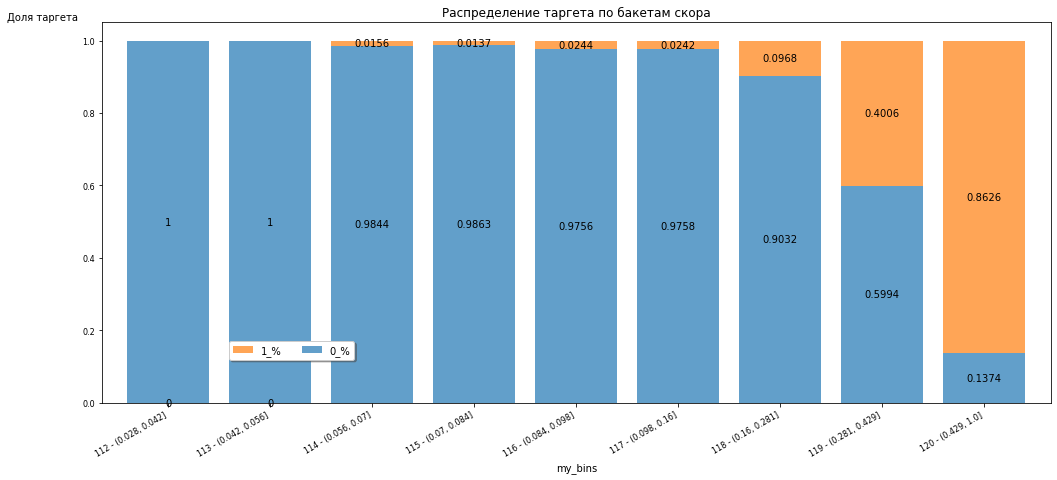

In [16]:
import warnings

warnings.filterwarnings("ignore")

percent_target_bucket_bar(df[['target', 'score']], scale='forced', type_fig='bar')

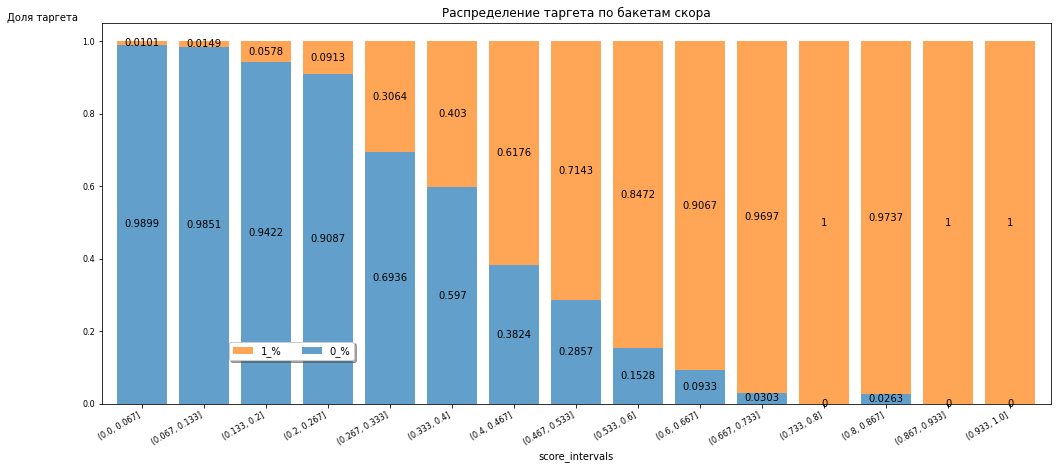

In [17]:
percent_target_bucket_bar(df[['target', 'score']], scale='equal', equal_count=15, type_fig='bar')

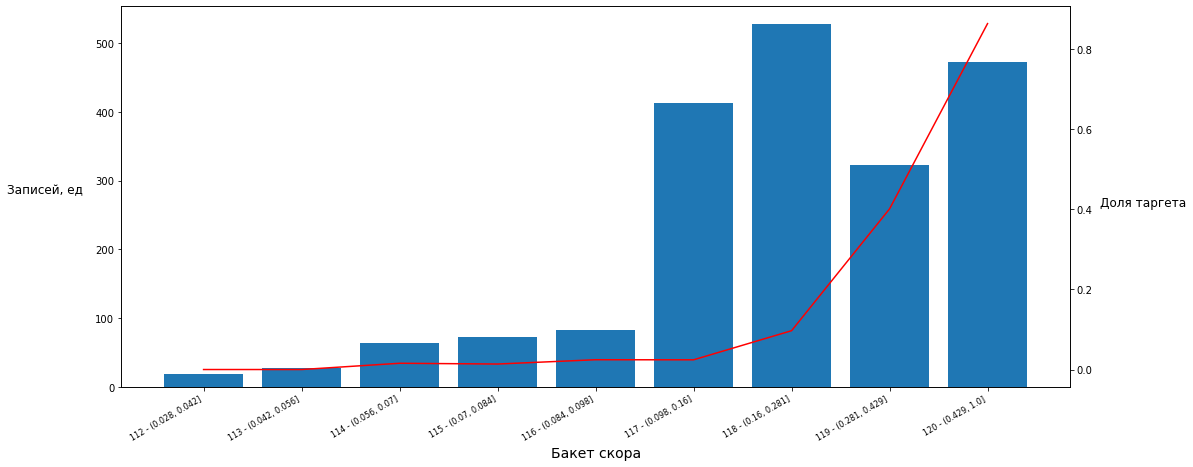

In [18]:
percent_target_bucket_bar(df[['target', 'score']], scale='forced', type_fig='bar_with_line')

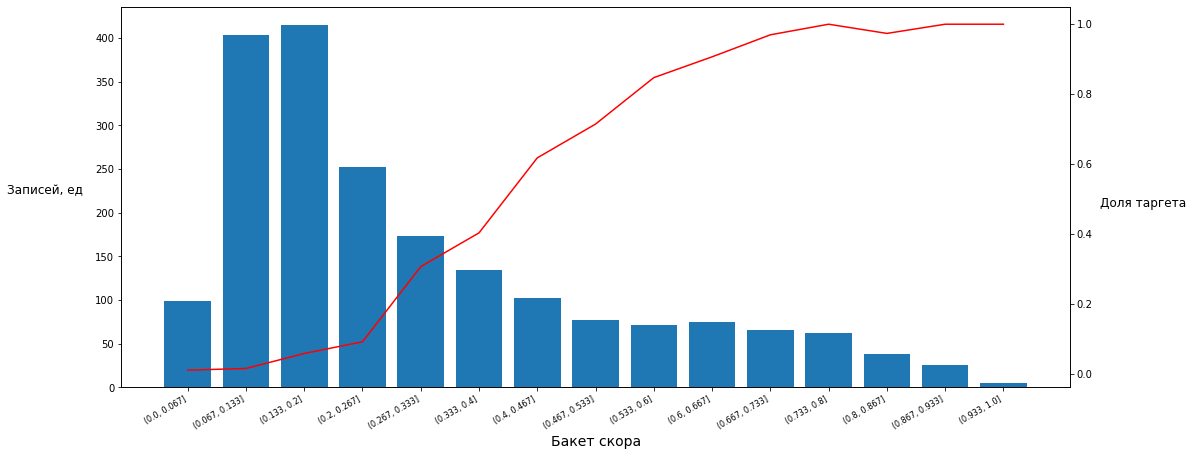

In [19]:
percent_target_bucket_bar(df[['target', 'score']], scale='equal', equal_count=15, type_fig='bar_with_line')

### 3. Доля таргета по бакетам скора в динамике по времени (если оно есть)

In [20]:
import datetime

In [21]:
start_date = datetime.datetime(2022, 1, 1)

end_date = datetime.datetime(2023, 12, 31)

In [22]:
random_date = start_date + datetime.timedelta(days=random.randint(0, (end_date - start_date).days)); random_date

datetime.datetime(2023, 11, 21, 0, 0)

<AxesSubplot:>

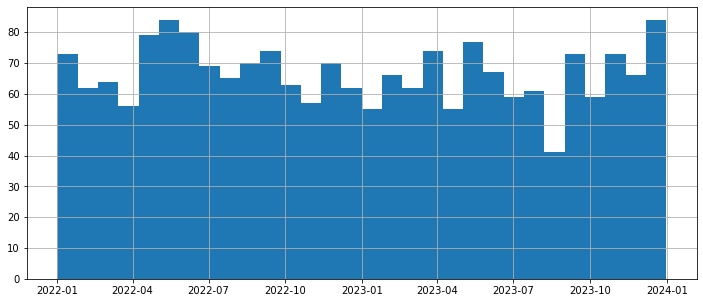

In [23]:
# Генерируем случайную дату для каждой записи

df['ДАТА_ЗАПИСИ'] = [start_date + datetime.timedelta(days=random.randint(0, (end_date - start_date).days)) for i in range(len(df))]

df.ДАТА_ЗАПИСИ.hist(bins=30, figsize=(12, 5))

In [24]:
my_scale_of_group = {0.0020000000000: 109, 
                     0.0140000000000: 110, 
                     0.0280000000000: 111, 
                     0.0420000000000: 112, 
                     0.0560000000000: 113, 
                     0.0700000000000: 114, 
                     0.0840000000000: 115, 
                     0.0980000000000: 116, 
                     0.1600000000000: 117, 
                     0.2811711454357: 118, 
                     0.4290040268516: 119, 
                     1.0000000000000: 120}

my_scale_of_group_eq = {0.2: 1, 
                        0.4: 2, 
                        0.6: 3,
                        0.8: 4,
                        1: 5}

In [25]:
def group_lines_in_time(df_i, period='months', interval_dict=my_scale_of_group):
    ''' 
    1. На вход - df из трех колонок: target, score, ДАТА_ЗАПИСИ (лучше всего дата без времени)
    2. На вход - размер периода, на которые раскидываем бакеты: months, quarters
    3. На вход - словарь с группами вида {верхняя граница: группа}
    
    На выходе - график зависимости доли таргета от времени для каждой группы своя линия 
    На выходе - словарь (при использовании return)
    
    '''
    
    if period == 'months':
        index_for_pivot = 'мес_год'
    elif period == 'quarters':
        index_for_pivot = 'квартал'
    
    gr_count = len(interval_dict)
    
    equal_bins = [round((1 / gr_count) * (ind+1), 3) for ind, val in enumerate(range(gr_count))]  # список равномерных границ согласно количеству групп 
    forced_bins = [round(i, 3) for i in list(interval_dict.keys())]                               # список границ согласно количеству групп их значению
    
    df_i['мес_год'] = df_i['ДАТА_ЗАПИСИ'].dt.year.astype(str) + '_' + df_i['ДАТА_ЗАПИСИ'].dt.month.astype(str).str.rjust(2, '0')    # индекс помесячный
    df_i['квартал'] = df_i['ДАТА_ЗАПИСИ'].dt.to_period('Q').astype(str)                                                             # индекс поквартальный
    df_i['groups'] = pd.cut(df_i['score'], [0]+forced_bins, labels=interval_dict.values())                                          # группа скора
    
    for_plot_pie = df_i.loc[df_i['score'].notna(), ['target', 'score', 'groups', 'мес_год', 'квартал']].copy()                      # убираем пустые скоры
    
    pie = pd.pivot_table(for_plot_pie, index=[index_for_pivot], columns=['groups', 'target'], aggfunc='count', fill_value=0).reset_index(drop=False)
    
    # мультииндекс по колонке убираем 
    pie.columns = [col[0] + '_' + str(col[1]).replace('.0', '') + '_' + str(col[2]).replace('.0', '') for col in pie.columns]
    
    groups_lst = sorted(list(interval_dict.values()))                                             # в словаре мы группы не повторяем
    
    for group in groups_lst:   
 
        pie[f'group_{str(group)}_%1'] = pie[f'score_{str(group)}_1'] / pie[[f'score_{str(group)}_0', f'score_{str(group)}_1']].sum(axis=1)
    
    fig = plt.figure(figsize=(18, 8))
    plt.gcf().set_facecolor('grey')                                                               # ЕСЛИ ХОТИМ КАКОЙ-ТО ФОН
    
    for group in groups_lst: 
        plt.plot(np.array(pie[f'{index_for_pivot}__']), np.array(pie[f'group_{group}_%1']), label=f'Group_{group}', marker='o')
    
    plt.title('Изменение Target (доля) в разрезе периодов и бакетов скора', fontsize=16)
    plt.legend()
    plt.xlabel('Время', fontsize=14)
    plt.ylabel('Default-Rate', fontsize=14)
    plt.xticks(fontsize=14, ha='right', rotation=50)
    plt.yticks(fontsize=14)
    plt.show()
    
    return interval_dict                                                                          # для отражения использованного словаря под графиком

### 
Помесячно обычно каша, т.к. мб мало данных... скорее всего смотреть будем поквартально

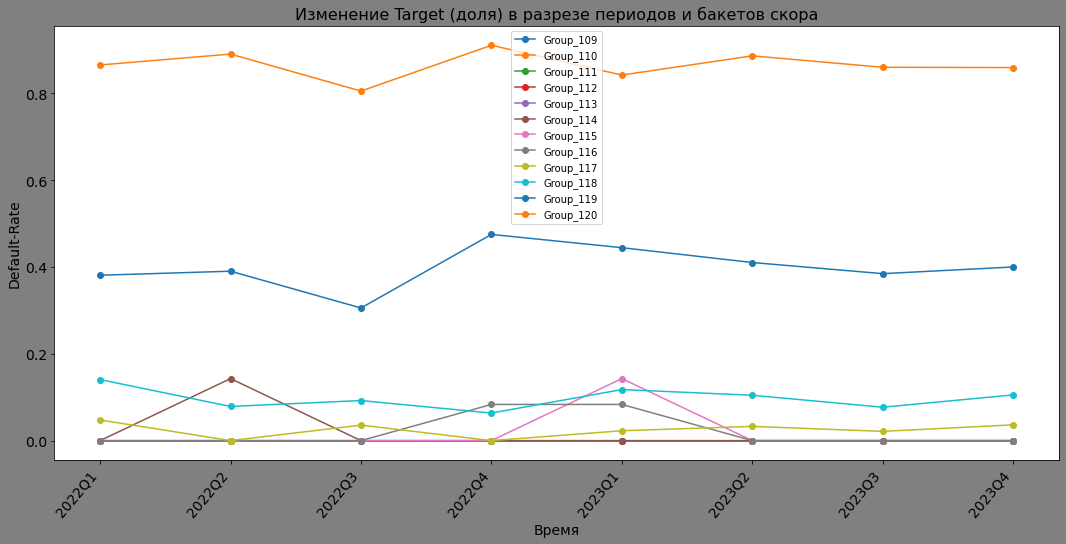

{0.002: 109,
 0.014: 110,
 0.028: 111,
 0.042: 112,
 0.056: 113,
 0.07: 114,
 0.084: 115,
 0.098: 116,
 0.16: 117,
 0.2811711454357: 118,
 0.4290040268516: 119,
 1.0: 120}

In [26]:
group_lines_in_time(df[['target', 'score', 'ДАТА_ЗАПИСИ']], period='quarters', interval_dict=my_scale_of_group)

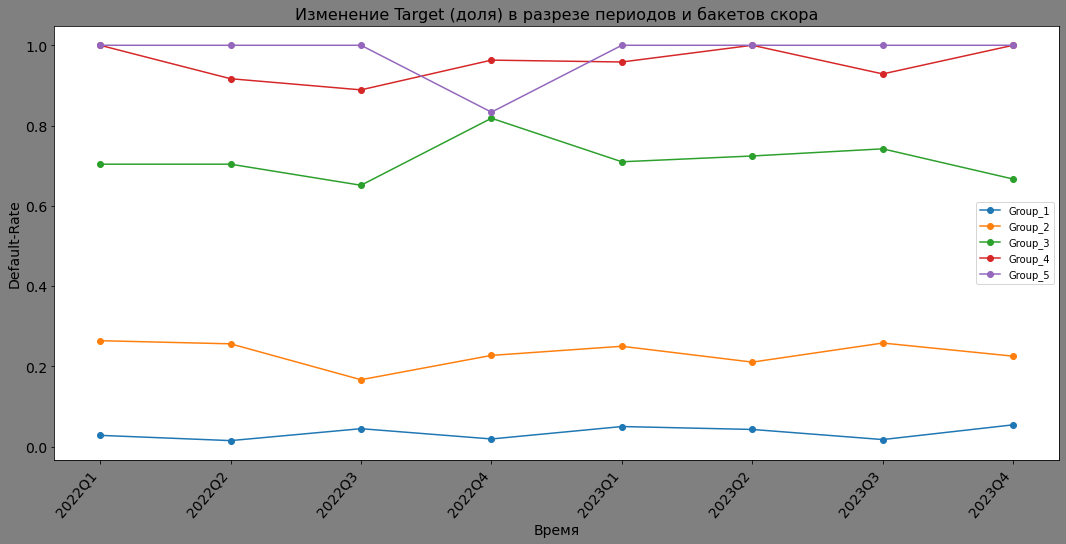

{0.2: 1, 0.4: 2, 0.6: 3, 0.8: 4, 1: 5}

In [27]:
group_lines_in_time(df[['target', 'score', 'ДАТА_ЗАПИСИ']], period='quarters', interval_dict=my_scale_of_group_eq) # поменяли словарь

### 4. Ежеквартальный, ежемесячный gini

In [28]:
def gini_in_time(df_i, period='months'):
    ''' 
    1. На вход - df из трех колонок: target, score, ДАТА_ЗАПИСИ (лучше всего дата без времени)
    2. На вход - Размер периода, на которые раскидываем бакеты: months, quarters
  
       На выход - график зависимости gini от времени
    
    '''
    df_i['year_month'] = df_i['ДАТА_ЗАПИСИ'].dt.year.astype(str) + '_' + df_i['ДАТА_ЗАПИСИ'].dt.month.astype(str).str.rjust(2, '0')    # индекс помесячный
    df_i['quarter'] = df_i['ДАТА_ЗАПИСИ'].dt.to_period('Q').astype(str)                                                                # индекс поквартальный

    
    # Поквартально
    # тут все сработает, если нет периодов с пустотами и внутри какого-то из периодов записи не только из одного класса
    
    if period=='months':
        period_col, gini_name = 'year_month', 'gini_m'
    elif period=='quarters':
        period_col, gini_name = 'quarter', 'gini_q'
    else:
        print('period error')
    
    for p in [i for i in df_i[period_col].unique()]:

        df_i.loc[df_i[period_col] == p, gini_name] = 2 * roc_auc_score(df_i.loc[df_i[period_col] == p, 'target'], 
                                                                       df_i.loc[df_i[period_col] == p, 'score']
                                                                      ) - 1
        
    viz = df_i.groupby(period_col, as_index=False).agg({gini_name: 'mean'}).sort_values(period_col)
    
    fig, ax = plt.subplots(figsize=(17, 5))

    ax = plt.gca()
    plt.gcf().set_facecolor('grey')
    ax.set_facecolor('ivory')

    plt.plot(viz[gini_name], marker='o', markersize=12)
    ax.set_xticks(range(len(viz[period_col])))
    ax.set_xticklabels(viz[period_col])
    ax.tick_params(axis='both', which='major', labelsize=8)
    plt.xlabel(period, fontsize=14)
    plt.ylabel('Gini-value', fontsize=14)
    plt.xticks(fontsize=14, rotation=50)
    plt.yticks(fontsize=14)
    plt.ylim(0.0, 1)
    plt.title(f'Gini по {period}', fontsize=16)
    #plt.show() 

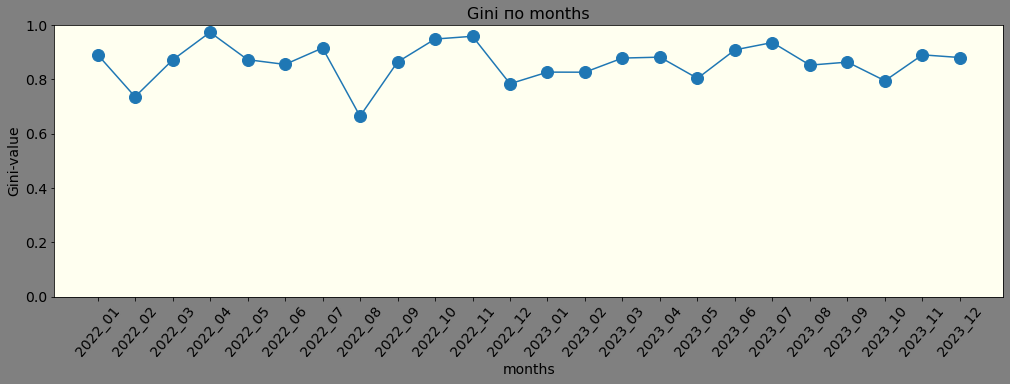

In [29]:
gini_in_time(df[['target', 'score', 'ДАТА_ЗАПИСИ']], period='months')

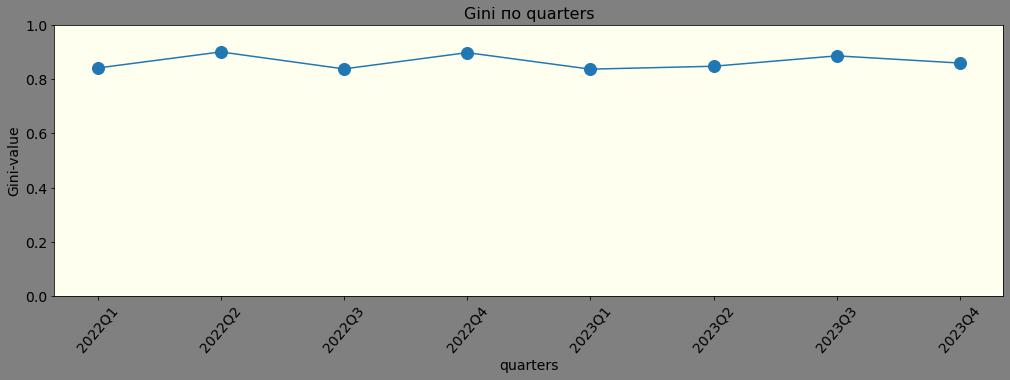

In [30]:
gini_in_time(df[['target', 'score', 'ДАТА_ЗАПИСИ']], period='quarters')

###
### 5. Пример Subplots с какой-то инфой

In [31]:
# Какое-то распределение количественной переменной в руб, например


df['random_limit'] = np.random.sample(len(df)) * 1000

In [32]:
# воткнем выброс

df.loc[1995, 'random_limit'] = 10_000

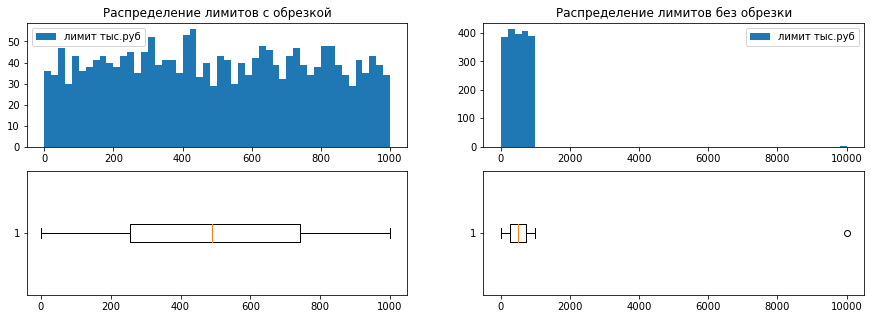

In [33]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))

plt.subplot(2, 2, 1)
first = plt.hist(df.loc[:, 'random_limit'], 
            label='лимит тыс.руб', 
            orientation='vertical',
            align='mid',
            bins=50, range=(0, 1_000))    # Если есть выброс и график уезжает, то тут мы обрежем нужную часть

plt.legend()
plt.title('Распределение лимитов с обрезкой')


plt.subplot(2, 2, 2)
second = plt.hist(df.loc[:, 'random_limit'], 
            label='лимит тыс.руб', 
            orientation='vertical',
            align='mid',
            bins=50)

plt.legend()
plt.title('Распределение лимитов без обрезки')


plt.subplot(2, 2, 3)
third = plt.boxplot(df.loc[:, 'random_limit'], vert=False)
plt.xlim(-40, 1_050)

plt.subplot(2, 2, 4)
fourth = plt.boxplot(df.loc[:, 'random_limit'], vert=False)

### 6. Все что мы знаем о Plotly

In [36]:
# import plotly.express as px

##### полезная ссыль
https://python-school.ru/blog/%D0%B2%D0%B8%D0%B7%D1%83%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F-%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85/plotly-basics/

In [34]:
df['score_random'] = np.random.sample(len(df))

In [46]:
df['category'] = [['cat_1', 'cat_2', 'cat_3'][random.randint(0, 2)] for i in range(len(df))]

In [48]:
df.head(3)

0         1         2         3         4         5         6  \
0  1.207879 -0.680614  2.539834  4.689493 -1.667815  3.686062 -1.494768   
1  0.242314  4.313863 -2.183849 -3.210983 -0.659669 -2.904159 -0.457231   
2 -0.271419  0.684969 -0.878567  6.552300 -0.487758  2.566656 -2.446467   

          7         8         9  ...        46        47        48        49  \
0 -1.691951  1.537045 -1.167368  ...  3.226447  0.603229  3.323430 -3.846711   
1 -0.811037  3.400930 -2.252385  ... -1.629968 -0.649141 -1.450946 -1.951799   
2  3.513706  2.390055  4.561699  ... -2.194370  2.482856  5.177373 -3.063220   

   target     score  ДАТА_ЗАПИСИ  random_limit  score_random  category  
0       0  0.124592   2023-02-17    902.803479      0.256837     cat_1  
1       0  0.111733   2023-11-28    427.540545      0.179692     cat_1  
2       0  0.056041   2023-05-21    918.916979      0.967531     cat_1  

[3 rows x 56 columns]

In [37]:
df.shape

(2000, 55)

#### plotly - Обычный точечный

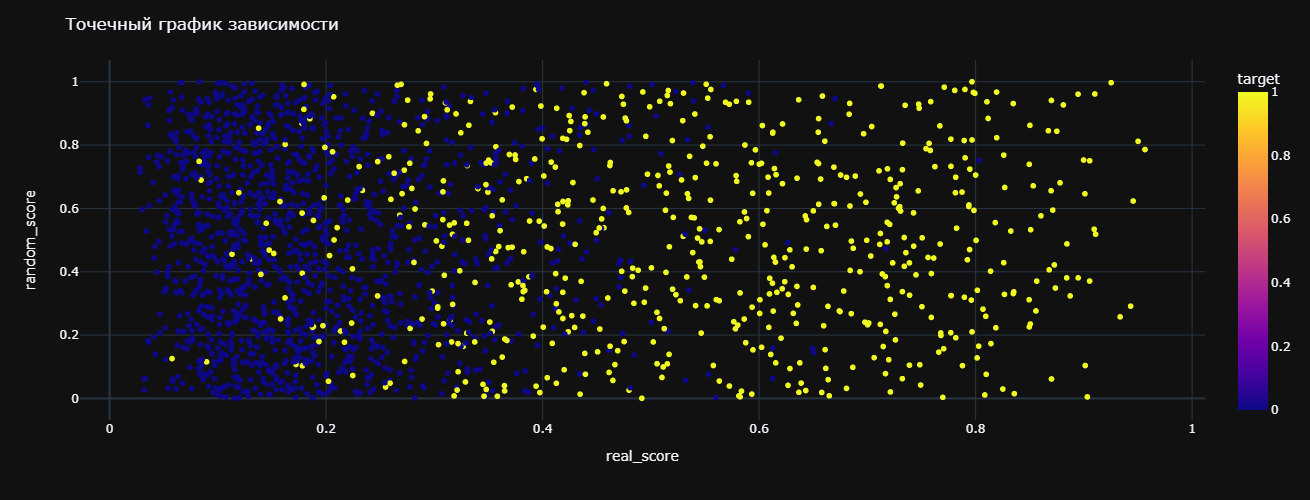

In [78]:
# Нажимаем на фотоаппаратик - получаем график в png
# Лассо select              - подсветить какую-нибудь неровную область
# Box select                - подсветить обычную прямоугольную область

fig = px.scatter(df, 
                 x='score', 
                 y='score_random', 
                 color='target', 
                 hover_data = {'ДАТА_ЗАПИСИ': True, 
                               'category': True, 
                               'random_limit': ':.0f', 
                               'target': True, 
                               'score': ':.3f', 
                               'score_random': ':.3f'})

# template - это как бы фон рисунка. Вот примеры template in ["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]

fig.update_layout(title='Точечный график зависимости', 
                  width=1000, 
                  height=500, 
                  xaxis_title='real_score', 
                  yaxis_title='random_score', 
                  template='plotly_dark', 
                  )

Фигура — это данные в JSON  
За отрисовку фигур (диаграмм, карт, рисунков и т.д.) ответственна библиотека Plotly.js языка JavaScript, но знать его совсем не нужно. Фигуры представляются данными в формате JSON (JavaScript Object Notation), который по структуре мало чем отличается от словаря (dict) в Python. Доступ к ним возможен через вызов класс plotly.graph_objects.Figure.
Чтобы посмотреть структуру в формате JSON, нужно использовать print(fig), а fig.show() отрисует саму фигуру.

In [123]:
fig['data'][0]['customdata'][:, 0][0].date()

datetime.date(2023, 2, 17)

Фигуры в виде дерева атрибутов  
Поскольку фигура представляется в JSON, то доступ к атрибутам осуществляется за счет полного прописывания пути. Например, запись layout.width обращается к ширине (width) макета (layout). Если же значением какого-либо атрибута является список (list), а не словарь, то используются квадратные скобки — layout.annotations[].text.
Для изменения значений атрибутов можно либо просто передать им новое значение, либо использовать методы обновления. Вот так в Python выглядят оба способа для изменения шрифта:
  
fig.layout.title.font.family="Open Sans"  
fig.update_layout(title_font_family="Open Sans")  
  
В Plotly есть три корневых атрибута: data, layout и frames.

In [129]:
# мы прям в объекте фигуры меняем тип отображения даты, теперь при наведении мы видим дату без времени

for time_ind in range(len(fig['data'][0]['customdata'][:, 0])):
    fig['data'][0]['customdata'][:, 0][time_ind] = fig['data'][0]['customdata'][:, 0][time_ind].date()

In [130]:
fig['data'][0]['customdata'][:, 0]

array([datetime.date(2023, 2, 17), datetime.date(2023, 11, 28),
       datetime.date(2023, 5, 21), ..., datetime.date(2022, 9, 30),
       datetime.date(2023, 9, 8), datetime.date(2023, 1, 3)], dtype=object)

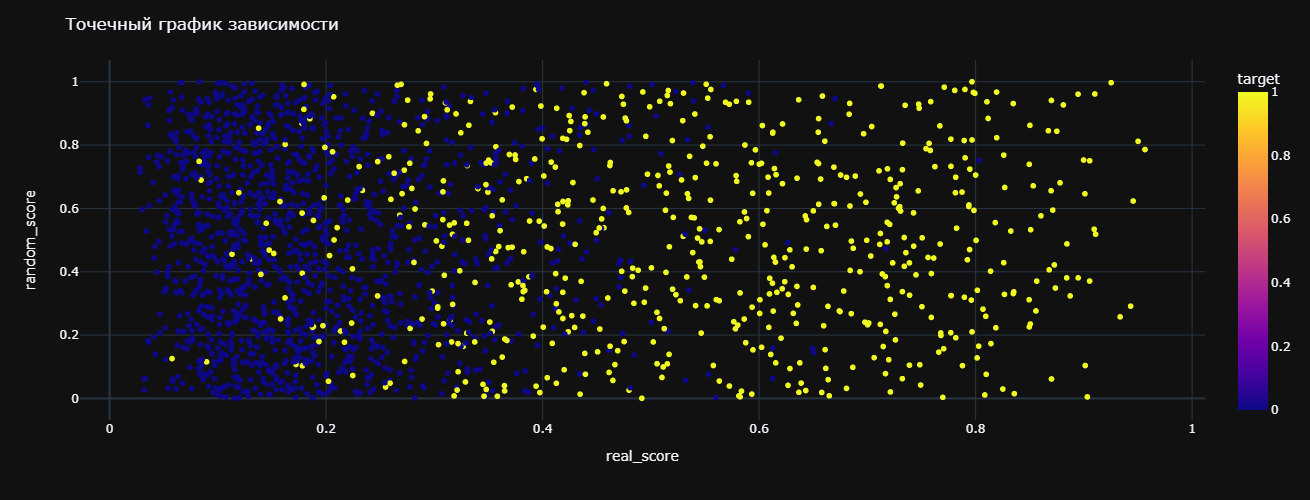

In [132]:
fig.show()

#### plotly - диаграмма

In [133]:
df.head(3)

0         1         2         3         4         5         6  \
0  1.207879 -0.680614  2.539834  4.689493 -1.667815  3.686062 -1.494768   
1  0.242314  4.313863 -2.183849 -3.210983 -0.659669 -2.904159 -0.457231   
2 -0.271419  0.684969 -0.878567  6.552300 -0.487758  2.566656 -2.446467   

          7         8         9  ...        46        47        48        49  \
0 -1.691951  1.537045 -1.167368  ...  3.226447  0.603229  3.323430 -3.846711   
1 -0.811037  3.400930 -2.252385  ... -1.629968 -0.649141 -1.450946 -1.951799   
2  3.513706  2.390055  4.561699  ... -2.194370  2.482856  5.177373 -3.063220   

   target     score  ДАТА_ЗАПИСИ  random_limit  score_random  category  
0       0  0.124592   2023-02-17    902.803479      0.256837     cat_1  
1       0  0.111733   2023-11-28    427.540545      0.179692     cat_1  
2       0  0.056041   2023-05-21    918.916979      0.967531     cat_1  

[3 rows x 56 columns]

In [134]:
# барплот как то можно построить , но он не очень понятный, проще другими средствами

# fig = px.bar(df, 
#              x='category', 
#              y='target', 
#              #color=''
#              )

# fig.show()

#### Трехмерный график

In [135]:
# Точечный трехмерный график 

fig = px.scatter_3d(df,                                     # сюда подаем датасет в предобработанном виде, что бы все остальное было колонками датасета
                    x='score', 
                    y='score_random', 
                    z='random_limit', 
                    height= 700,                            # высота в пикселях
                    width = 700,                            # ширина в пикселях
                    #size='col_size',                       # колонка где указаны размеры меток , но сама по себе она не срабатывает
                    color='target',                         # разная раскраска по колонке
                    opacity=1,                              # прозрачность от 0 до 1
                    title='График зависимости 3-ёх вечличин',
                    #hover_name = 'ДЕНЬ_ЗАЯВКИ',
                    hover_data = {'ДАТА_ЗАПИСИ': True, 
                                  #'НОМЕР_ДП': True, 
                                  'random_limit': ':.0f', 
                                  'target': True, 
                                  'score': ':.3f', 
                                  'score_random': ':.3f'}   # отсвечивание данных в табличке при наведении с укаанием формата  True == формат по умолчанию
                   )
fig.update_traces(marker_size = 4)                          # изменение размера точек

#### можно проиллюстрировать какую-нибудь самописную формулу, связывающую показатели

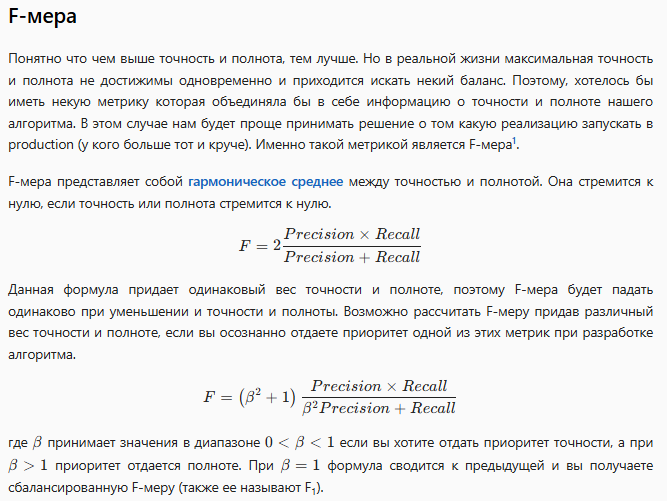

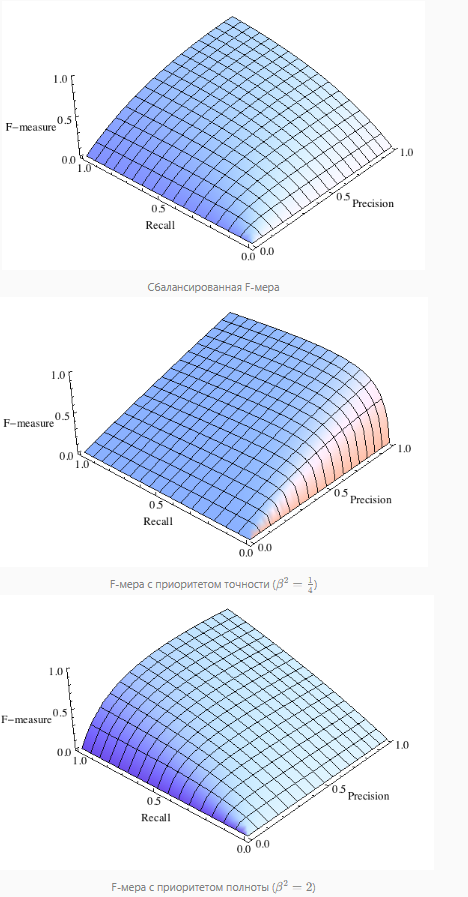

In [136]:
b = 1

df['harmonic_avg'] = (b**2 + 1) * (df['score'] * df['score_random']) / (b**2 * df['score'] + df['score_random'])

In [137]:
b = 0.25

df['harmonic_avg_beveled'] = (b**2 + 1) * (df['score'] * df['score_random']) / (b**2 * df['score'] + df['score_random'])

In [153]:
# Точечный трехмерный график 

fig = px.scatter_3d(df,                                     # сюда подаем датасет в предобработанном виде, что бы все остальное было колонками датасета
                    x='score', 
                    y='score_random', 
                    z='harmonic_avg', 
                    height= 700,                            # высота в пикселях
                    width = 700,                            # ширина в пикселях
                    #size='col_size',                       # колонка где указаны размеры меток , но сама по себе она не срабатывает
                    color='target',                         # разная раскраска по колонке
                    opacity=1,                              # прозрачность от 0 до 1
                    title='График зависимости 3-ёх величин',
                    #hover_name = 'ДЕНЬ_ЗАЯВКИ',
                    hover_data = {'ДАТА_ЗАПИСИ': True, 
                                  #'НОМЕР_ДП': True, 
                                  'harmonic_avg': ':.3f', 
                                  'target': True, 
                                  'score': ':.3f', 
                                  'score_random': ':.3f'}   # отсвечивание данных в табличке при наведении с укаанием формата  True == формат по умолчанию
                   )
fig.update_traces(marker_size = 4)                          # изменение размера точек

In [154]:
fig['data'][0]['customdata'][:, 0][0].date()

datetime.date(2023, 2, 17)

In [155]:
# мы прям в объекте фигуры меняем тип отображения даты, теперь при наведении мы видим дату без времени

for time_ind in range(len(fig['data'][0]['customdata'][:, 0])):
    fig['data'][0]['customdata'][:, 0][time_ind] = fig['data'][0]['customdata'][:, 0][time_ind].date()

In [156]:
# fig['data']

In [157]:
# теперь наводишь на точку и видишь дату так, как ты ее указал

fig.show()

#### Plotly subplots

In [158]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots